In [116]:
import numpy as np
import math
import matplotlib.pyplot as plt
from CoolProp.CoolProp import PropsSI as prop
from CoolProp.CoolProp import PhaseSI as phase



In [126]:
#############################################
### Correlations and functions definition ###
#############################################

def f_chur(Re,D):
    
    rug = 0.0046e-2 #Rugosidade para o alumínio em m
    A = (2.457*np.log(1/((7/Re)**0.9+0.27*(rug/D))))**16
    B = (37530/Re)**16
    parameter = 8*((8/Re)**12 + (A+B)**(-3/2))**(1/12)
    
    return(parameter)

def dpdz_mull_heck(x,G,D,f_l,rho_l,f_v,rho_v):
    
    dpdz_lo = f_l*G**2/(2*D*rho_l)
    dpdz_vo = f_v*G**2/(2*D*rho_v)
    A = dpdz_lo+2*(dpdz_vo-dpdz_lo)*x
    parameter = A*(1-x)**(1/3) + dpdz_vo*x**3
    
    return(parameter)

def Xtt(x,G,D,f_l,rho_l,f_v,rho_v):
    
    dpdz_l = 2*f_l*G**2*(1-x)**2/(D*rho_l)
    dpdz_v = 2*f_v*G**2*x**2/(D*rho_v)
    parameter = math.sqrt(dpdz_l/dpdz_v)
    
    return(parameter)


def  eta_bifasico(Re_lo,xtt,Pr_lo,k_lo,D):
    
    Nu_lo = Re_lo**(4/5)*Pr_lo**0.4
    eta_lo = Nu_lo*k_lo/D
    parameter = eta_lo*3.3775*xtt**-0.6285
    
    return(parameter)

def  eta_mono(Re,Pr,k,D):
    
    Nu = 0.023*Re**(4/5)*Pr**(1/3)
    parameter = Nu*k/D

    return(parameter)

def eta_air(Re_air,Pr_air,G_air,cp_air,Ap,Af):
    
    eps= (Ap+Af)/Ap
    j = 0.138*Re_air**(-0.281)*eps**(-0.407)
    St = j*Pr_air**(-2/3)
    parameter = St*G_air*cp_air
    
    return(parameter)

def surf_eff(Ap,Af,D_in,delta,eta_ar,k_al,x_t,x_l):
    
    r=D_in/2
    M=x_t
    L=math.sqrt((x_t/2)**2+x_l**2)    
    phi=L/M
    psi=M/r
    R_eq = r*1.27*psi*(phi-0.3)**(1/2)
    
    m=math.sqrt(2*eta_ar/(k_al*delta))
    var_phi = (R_eq/r -1)*(1+0.35*np.log(R_eq/r))
    eff_fin=np.tanh(m*r*var_phi)/(m*r*var_phi)
    parameter = 1-(1-eff_fin)*(Af/(Ap+Af))
    
    return(parameter)
    
def epsilon(C_ar,C_r134a,NTU,quality_r134a):
    
    if quality_r134a < 1:
        
        parameter = 1 - np.exp(-NTU)
    
    elif quality_r134a == 1: 
        
        if C_ar >= C_r134a:
        
            c = C_r134a/C_ar
            parameter = 1 - np.exp(-(1/c)*(1-np.exp(-c*NTU)))
            
        if C_ar < C_r134a:
            
            c = C_ar/C_r134a
            parameter = (1/c)*(1-np.exp(1-c*(1-np.exp(-NTU))))
    
    return(parameter)

def NUT(C_ar,C_r134a,eps,quality_r134a):
    
    if quality_r134a < 1:
        
        parameter = - np.log(1 - eps)
    
    elif quality_r134a == 1: 
        
        if C_ar >= C_r134a:
        
            c = C_r134a/C_ar
            parameter = - np.log(c*np.log(1-eps)+1)/c
            
        if C_ar < C_r134a:
            
            c = C_ar/C_r134a
            parameter = - np.log(1 + np.log(1-eps*c)/c)
    
    return(parameter)


In [127]:
###############################
### Equações de conservação ###
###############################

def movimento(Pin,W,Di,G,v,mu_l):
    
    Re = G*Di/mu_l
    f = f_chur(Re,Di)
    tau = f*G**2*v/8
    parameter = Pin - tau*np.pi*W*4/(np.pi*Di)
    
    return(parameter)

def movimento_dryout(Pin,Pout,Di,G,v,mu_l):
    
    Re = G*Di/mu_l
    f = f_chur(Re,Di)
    tau = f*G**2*v/8
    parameter = -(Pout - Pin)*np.pi*Di/(tau*np.pi*4)
    
    return(parameter)

def energia_bi(hin,Pin,Pavg,Qavg,mfrin,Tain,Taavg,Pa,mfra,W,Di,A_c,A_p,A_s,A_t,deltaf,kal,xt,xl):
    
    mu_l =prop('V','P',Pavg,'Q',0,'R134a')
    mu_v = prop('V','P',Pavg,'Q',1,'R134a')
    rho_l = prop('D','P',Pavg,'Q',0,'R134a')
    rho_v = prop('D','P',Pavg,'Q',1,'R134a')
    
    G = mfrin/(np.pi*Di**2/4)
    G_l = G*(1-Qavg)
    G_v = G*Qavg
    Re_l = G_l*Di/mu_l
    Re_v = G_v*Di/mu_v
    f_l =f_chur(Re_l,Di)
    f_v =f_chur(Re_v,Di)
    
    xtt = Xtt(Qavg,G,Di,f_l,rho_l,f_v,rho_v)
    Re_lo = G*Di/prop('V','P',Pavg,'Q',0,'R134a')
    Pr_lo = prop('PRANDTL','P',Pavg,'Q',0,'R134a')
    k_lo = prop('L','P',Pavg,'Q',0,'R134a')
    
    etabi=eta_bifasico(Re_lo,xtt,Pr_lo,k_lo,Di)
    Tin = prop('T','P',Pin,'H',hin,'R134a')
    
    rho_a = prop('D','T',Taavg,'P',Pa,'Air')
    mu_a = prop('D','T',Taavg,'P',Pa,'Air')
    Pr_a = prop('PRANDTL','T',Taavg,'P',Pa,'Air')
    cp_a = prop('C','T',Taavg,'P',Pa,'Air')
    #mfr_a = rho_a*vfrin
    G_a= (mfra/A_c)
    Re_a = G_a*D_o/mu_a
    
    eta_a = eta_air(Re_a,Pr_a,G_a,cp_a,A_p,A_s)
    eff_surf = surf_eff(A_p,A_s,Di,deltaf,eta_a,kal,xt,xl)

    C_a = mfra*cp_a
    cp_r=prop('C','P',Pavg,'Q',Qavg,'R134a')
    C_r = mfrin*cp_r
    #Ph = phase('P',Pavg,'Q',Qavg,'R134a')
    UA = (1/(etabi*np.pi*Di*W) + 1/(eff_surf*eta_a*A_t))**-1
    Ntu = UA/C_a

    eff = epsilon(C_a,C_r,Ntu,Qavg)
    parameter2 = eff*C_a*(Tain-Tin)
    parameter = hin + parameter2*4/(G*np.pi*Di**2)
    
    return(parameter,parameter2)


def energia_mono(hin,Pin,Pavg,havg,mfrin,Tain,Taavg,Pa,mfra,W,Di,A_c,A_p,A_s,A_t,deltaf,kal,xt,xl):
    
    mu_v = prop('V','P',Pavg,'H',havg,'R134a')
    rho_v = prop('D','P',Pavg,'H',havg,'R134a')
    Pr_v = prop('PRANDTL','P',Pavg,'H',havg,'R134a')
    k_v = prop('L','P',Pavg,'H',havg,'R134a')
    
    G = mfrin/(np.pi*Di**2/4)
    Re_v = G*Di/mu_v
    f_v =f_chur(Re_v,Di)
   
    etamono=eta_mono(Re_v,Pr_v,k_v,Di)
    Tin = prop('T','P',Pin,'H',hin,'R134a')
    
    rho_a = prop('D','T',Taavg,'P',Pa,'Air')
    mu_a = prop('V','T',Taavg,'P',Pa,'Air')
    Pr_a = prop('PRANDTL','T',Taavg,'P',Pa,'Air')
    cp_a = prop('C','T',Taavg,'P',Pa,'Air')
    #mfr_a = rho_a*vfrin
    G_a= (mfra/A_c)
    Re_a = G_a*D_o/mu_a
    
    eta_a = eta_air(Re_a,Pr_a,G_a,cp_a,A_p,A_s)
    eff_surf = surf_eff(A_p,A_s,Di,deltaf,eta_a,kal,xt,xl)

    C_a = mfra*cp_a
    cp_v=prop('C','P',Pavg,'H',havg,'R134a')
    C_v = mfrin*cp_v
    #Ph = phase('P',Pavg,'Q',Qavg,'R134a')

    UA = (1/(etamono*np.pi*Di*W) + 1/(eff_surf*eta_a*A_t))**-1
    Ntu = UA/min(C_a,C_v)

    eff = epsilon(C_a,C_v,Ntu,1)
    parameter2 = eff*min(C_a,C_v)*(Tain-Tin)
    parameter = hin + parameter2*4/(G*np.pi*Di**2)
    
    return(parameter,parameter2)

def energia_dryout(hin,Q_ht_bif,Pin,Pavg,Qavg,mfrin,Tain,Taavg,Pa,mfra,L,Di,A_c,A_p,A_s,A_t,deltaf,kal,xt,xl):
    
    Qin = prop('Q','P',Pin,'H',hin,'R134a')
    #hsat = prop('H','P',Pavg,'Q',1,'R134a')
    Tin = prop('T','P',Pin,'H',hin,'R134a')
    
    #rho_a = prop('D','T',Taavg,'P',Pa,'Air')
    mu_a = prop('V','T',Taavg,'P',Pa,'Air')
    Pr_a = prop('PRANDTL','T',Taavg,'P',Pa,'Air')
    cp_a = prop('C','T',Taavg,'P',Pa,'Air')
    #C_a = mfra*cp_a
    #cp_r=prop('C','P',Pavg,'Q',Qavg,'R134a')    
    #C_r = mfrin*cp_r
    
    mu_l =prop('V','P',Pavg,'Q',0,'R134a')
    mu_v = prop('V','P',Pavg,'Q',1,'R134a')
    rho_l = prop('D','P',Pavg,'Q',0,'R134a')
    rho_v = prop('D','P',Pavg,'Q',1,'R134a')
    
    G = mfrin/(np.pi*Di**2/4)
    G_l = G*(1-Qavg)
    G_v = G*Qavg
    Re_l = G_l*Di/mu_l
    Re_v = G_v*Di/mu_v
    f_l =f_chur(Re_l,Di)
    f_v =f_chur(Re_v,Di)
    
    xtt = Xtt(Qavg,G,Di,f_l,rho_l,f_v,rho_v)
    Re_lo = G*Di/prop('V','P',Pavg,'Q',0,'R134a')
    Pr_lo = prop('PRANDTL','P',Pavg,'Q',0,'R134a')
    k_lo = prop('L','P',Pavg,'Q',0,'R134a')
    
    etabi=eta_bifasico(Re_lo,xtt,Pr_lo,k_lo,Di)

    #mfr_a = rho_a*vfrin
    G_a= (mfra/A_c)
    Re_a = G_a*D_o/mu_a
    
    eta_a = eta_air(Re_a,Pr_a,G_a,cp_a,A_p,A_s)
    eff_surf = surf_eff(A_p,A_s,Di,deltaf,eta_a,kal,xt,xl)
    
    
    #U = (1/(etabi*np.pi*Di*L) + 1/(eff_surf*eta_a))**-1
    U = (1/etabi + 1/(eff_surf*eta_a))**-1
    
    parameter = Q_ht_bif/(U*(Taavg-Tin))
    
    return(parameter)

def wall_temp(Travg,eta_r,Di,W,Taavg,eta_a,A_t):
    
    parameter=(Travg*eta_r*np.pi*Di*W + Taavg*eta_a*A_t)/(eta_r*np.pi*Di*W + eta_a*A_t)
    
    return(parameter)

def energia_ar(Tain,Taavg,Pa,mfra,Q_ht):
    
    cp_a = prop('C','T',Taavg,'P',Pa,'Air')
    parameter = Tain - Q_ht/(mfra*cp_a)
    
    return(parameter)


    

In [128]:
################
### Geometry ###
################

W=300e-3
L = 190e-3
H=60e-3
nt_l = 10
nt_v = 2
delta_f = 0.15e-3
x_t = 11e-3
x_l = 19e-3
D_i = 6.7e-3
D_o=7.9e-3
L_t=W

# Region I

nf_I = 23
nt_I = 6
L_I = 3*x_l
Ap_I = np.pi*D_o*(W-nf_I*delta_f)*nt_I+2*(L_I*H - np.pi*D_o**2/4*nt_I)
As_I = 2*(L_I*H - np.pi*D_o**2/4*nt_I)*(nf_I+1)+H*delta_f*nf_I
At_I = Ap_I+As_I

two_a_I = (x_t - D_o) - (x_t-D_o)*delta_f*nf_I/W
b_I = ((x_t/2)**2+x_l**2)**(1/2) - D_o - (x_t-D_o)*delta_f*nf_I/W

c_I = min(two_a_I,2*b_I)

Ac_I = (H/x_t-1)*c_I*W+(x_t-D_o)*W -(x_t - D_o)*delta_f*nf_I 

# Region II

nf_II = 47
nt_II = 6
L_II = 3*x_l
Ap_II = np.pi*D_o*(W-nf_II*delta_f)*nt_II+2*(L_II*H - np.pi*D_o**2/4*nt_II)
As_II = 2*(L_II*H - np.pi*D_o**2/4*nt_II)*(nf_II+1)
At_II = Ap_II+As_II

two_a_II = (x_t - D_o) - (x_t-D_o)*delta_f*nf_II/W
b_II = ((x_t/2)**2+x_l**2)**(1/2) - D_o - (x_t-D_o)*delta_f*nf_II/W

c_II = min(two_a_II,2*b_II)

Ac_II = (H/x_t-1)*c_II*W+(x_t-D_o)*W -(x_t - D_o)*delta_f*nf_II

# Region III

nf_III = 47
nt_III = 8
L_III = 4*x_l
Ap_III = np.pi*D_o*(W-nf_III*delta_f)*nt_III+2*(L_III*H - np.pi*D_o**2/4*nt_III)
As_III = 2*(L_III*H - np.pi*D_o**2/4*nt_III)*(nf_III+1)+H*delta_f*nf_III
At_III = Ap_III+As_III

two_a_III = (x_t - D_o) - (x_t-D_o)*delta_f*nf_III/W
b_III = ((x_t/2)**2+x_l**2)**(1/2) - D_o - (x_t-D_o)*delta_f*nf_III/W

c_III = min(two_a_III,2*b_III)

Ac_III = (H/x_t-1)*c_III*W+(x_t-D_o)*W -(x_t - D_o)*delta_f*nf_III

In [129]:
###############
### Circuit ###
###############

#index function
def j_index(value,jcircuit):
    
    ind_1, ind_2 = np.where(jcircuit == value)

    return(ind_1,ind_2)

#Paralelo
j_circuit=np.zeros((10,2))

for k in range(2):
  
    for j in range(10):
        
        if k == 0:
            j_circuit[j][k] = 9-j
        else:
            j_circuit[j][k] = 9+1+j

# ccorrente

j_circuit=np.zeros((10,2))
  
for j in range(10):

    for k in range(2):
        
        if j % 2 == 0:
            j_circuit[j][0] = (9-j)*(2)+1
            j_circuit[j][1] = (9-j)*(2)
        else:
            j_circuit[j][0] = (9-j)*(2)
            j_circuit[j][1] = (9-j)*(2)+1
            
# ccorrente

j_circuit=np.zeros((10,2))
  
for j in range(10):

    for k in range(2):
        
        if j % 2 == 0:
            j_circuit[j][0] = (j)*(2)+1
            j_circuit[j][1] = (j)*(2)
        else:
            j_circuit[j][0] = (j)*(2)
            j_circuit[j][1] = (j)*(2)+1

In [130]:
j_circuit

array([[  1.,   0.],
       [  2.,   3.],
       [  5.,   4.],
       [  6.,   7.],
       [  9.,   8.],
       [ 10.,  11.],
       [ 13.,  12.],
       [ 14.,  15.],
       [ 17.,  16.],
       [ 18.,  19.]])

In [131]:
##############################
### Inputs and first guess ###
##############################

#Test 1
'''Pr_inlet = 0.779e5
Q_inlet = 0.427
Ta_inlet = -20.7+273.15
mfrr_inlet = 3.2/3600
vfra_inlet = 50.5/3600'''

'''#Test 2
Pr_inlet = 0.795e5
Q_inlet = 0.432
Ta_inlet = -11.4+273.15#
mfrr_inlet = 2.6/3600
vfra_inlet = 50.8/3600'''

#Test 3
'''Pr_inlet = 0.785e5
Q_inlet = 0.43
Ta_inlet = -14.8+273.15#
mfrr_inlet = 2.8/3600
vfra_inlet = 49.3/3600'''

#test resultados

Q_inlet = 0.34
Pr_inlet = prop('P','T',-31+273.15,'Q',Q_inlet,'R134a')
Ta_inlet = -15+273.15#
mfrr_inlet = 5.2/3600
vfra_inlet = 50/3600

Tr_inlet = prop('T','P',Pr_inlet,'Q',Q_inlet,'R134a')
hr_inlet = prop('H','P',Pr_inlet,'Q',Q_inlet,'R134a')
hr_outlet = prop('H','P',Pr_inlet,'Q',1,'R134a')
G_r = mfrr_inlet/(np.pi*D_i**2/4)
Pa_inlet = 101325
rhoa_inlet = prop('D','P',Pa_inlet,'T',Ta_inlet,'Air')
mfra_inlet = rhoa_inlet*vfra_inlet
k_al = 237


hr_in = np.linspace(hr_inlet,hr_outlet,20)#np.ones((20))*hr_inlet 
hr_out = np.linspace(hr_inlet,hr_outlet,20)#np.ones((20))*hr_inlet

Tref_in=np.zeros((20))
Tref_out=np.zeros((20))
Pr_in=np.ones((20))*Pr_inlet
Pr_out=np.ones((20))*Pr_inlet
Qr_in=np.ones((20))*Q_inlet
Qr_out=np.ones((20))*Q_inlet
#Qr_in[0]=Q_inlet
Q_ht_r=np.zeros((20))
eta_r=np.zeros((20))
eta_airside=np.zeros((20))
#Tw=np.ones((20))*(Tr_inlet+1)
Ta_in=np.linspace(Ta_inlet,Tr_inlet,10)#np.ones((10))*(Tr_inlet)
Ta_out=np.linspace(Ta_inlet,Tr_inlet,10)#np.ones((10))*(Tr_inlet)
Ta_in[0]=Ta_inlet

hr_out_cycle = np.zeros((20))
Pr_out_cycle = np.zeros((20))
Ta_out_cycle = np.zeros((10))
hr_out_cycle_new = np.zeros((20))
Pr_out_cycle_new = np.zeros((20))
Ta_out_cycle_new = np.zeros((10))

Ap=np.zeros((10,2))
As=np.zeros((10,2))
At=np.zeros((10,2))
Ac=np.zeros((10,2))

Ap[0:4,:]=Ap_I
Ap[4:7,:]=Ap_II
Ap[7:10,:]=Ap_III

As[0:4,:]=As_I
As[4:7,:]=As_II
As[7:10,:]=As_III

Ac[0:4,:]=Ac_I
Ac[4:7,:]=Ac_II
Ac[7:10,:]=Ac_III

At[0:4,:]=Ap_I+As_I
At[4:7,:]=Ap_II+As_III
At[7:10,:]=Ap_III+As_III


In [132]:
####################
### Main Routine ###
####################

tube_it=1000000000
air_it=10000000000
cycle_it=100000000
dry_it = 100000000

alpha_tube_nodryout = 0
alpha_air = 0
alpha_cycle = 0
alpha_dry = 0

Tol_cycle = 1e-4
Tol_air = 1e-2
Tol_tube = 1e-2
tol_dryout = 1e-2

n_dry = 10

for res in range(cycle_it):
    
    hr_out_cycle_old = np.copy(hr_out)
    Pr_out_cycle_old = np.copy(Pr_out)
    Ta_out_cycle_old = np.copy(Ta_out)
    

    ############
    ### Tube ###
    ############
    
    for ind in range(20):

        ind_j,ind_k = j_index(ind,j_circuit)
        Tr_in = prop('T','P',Pr_in[ind],'H',hr_in[ind],'R134a')
        Ta_avg = (Ta_in[int(ind_j)]+Ta_out_cycle_old[int(ind_j)])/2 
        Q_in = abs(prop('Q','P',Pr_in[ind],'H',hr_in[ind],'R134a'))
        #Q_out = abs(prop('Q','P',Pr_out_cycle_old[ind],'H',hr_out_cycle_old[ind],'R134a'))
        Pr_out_old_it = float(np.copy(Pr_out_cycle_old[ind]))
        hr_out_old_it = float(np.copy(hr_out_cycle_old[ind]))
        Q_out = abs(prop('Q','P',Pr_out_old,'H',hr_out_old,'R134a'))

        for res in range(tube_it):
            
            Pr_out_old = Pr_out_old_it
            hr_out_old = hr_out_old_it
            Pr_avg = (Pr_in[ind]+Pr_out_old)/2
            hr_avg = (hr_in[ind]+hr_out_old)/2
            Q_avg = (Q_in+Q_out)/2

            rho_r = prop('D','P',Pr_in[ind],'H',hr_in[ind],'R134a')
            v_r = 1/rho_r
            
            if Q_in < 1 and Q_out < 1 :
                mu_r = prop('V','P',Pr_in[ind],'Q',0,'R134a')
                Pr_out_new = movimento(Pr_in[ind],W,D_i,G_r,v_r,mu_r)
                hr_out_new,Q_ht_r[ind] = energia_bi(hr_in[ind],Pr_in[ind],Pr_in[ind],Q_in,mfrr_inlet,Ta_in[int(ind_j)],Ta_avg,Pa_inlet,mfra_inlet/2,W,D_i,Ac[ind_j,ind_k],Ap[ind_j,ind_k],As[ind_j,ind_k],At[ind_j,ind_k],delta_f,k_al,x_t,x_l)
                alpha_tube=alpha_tube_nodryout

            
            elif Q_in == 1 and Q_out ==1 : 
                mu_r = prop('V','P',Pr_in[ind],'H',hr_in[ind],'R134a')
                Pr_out_new = movimento(Pr_in[ind],W,D_i,G_r,v_r,mu_r)
                hr_out_new,Q_ht_r[ind] = energia_mono(hr_in[ind],Pr_in[ind],Pr_in[ind],hr_in[ind],mfrr_inlet,Ta_in[int(ind_j)],Ta_avg,Pa_inlet,mfra_inlet/2,W,D_i,Ac[ind_j,ind_k],Ap[ind_j,ind_k],As[ind_j,ind_k],At[ind_j,ind_k],delta_f,k_al,x_t,x_l)
                alpha_tube=alpha_tube_nodryout

                
            elif Q_in < 1 and Q_out == 1:
                
                
                hr_in_dry = hr_in[ind]
                #hr_out_dry = hr_out_old
                Pr_in_dry = Pr_in[ind]
                #Pr_out_dry = Pr_out_old
                Q_ht_temp = 0
                F_bi = 0+1/n_dry
                
                for ind_dry in range(n_dry):
                    
                    Q_in_dry = abs(prop('Q','P',Pr_in_dry,'H',hr_in_dry,'R134a'))
                    
                    if Q_in_dry < 1:
                        mu_r = prop('V','P',Pr_in_dry,'Q',0,'R134a')
                        Pr_out_dry = movimento(Pr_in_dry,W/n_dry,D_i,G_r,v_r,mu_r)
                        hr_out_dry,Q_ht_r_dry = energia_bi(hr_in_dry,Pr_in_dry,Pr_in_dry,Q_in_dry,mfrr_inlet,Ta_in[int(ind_j)],Ta_avg,Pa_inlet,mfra_inlet/(2*n_dry),W/n_dry,D_i,Ac[ind_j,ind_k]/n_dry,Ap[ind_j,ind_k]/n_dry,As[ind_j,ind_k]/n_dry,At[ind_j,ind_k]/n_dry,delta_f,k_al,x_t,x_l)
                        F_bi += 1/n_dry
                        
                    elif Q_in_dry == 1: 
                        mu_r = prop('V','P',Pr_in_dry,'H',hr_in_dry,'R134a')
                        Pr_out_dry = movimento(Pr_in_dry,W/n_dry,D_i,G_r,v_r,mu_r)
                        hr_out_dry,Q_ht_r_dry = energia_mono(hr_in_dry,Pr_in_dry,Pr_in_dry,hr_in_dry,mfrr_inlet,Ta_in[int(ind_j)],Ta_avg,Pa_inlet,mfra_inlet/(2*n_dry),W/n_dry,D_i,Ac[ind_j,ind_k]/n_dry,Ap[ind_j,ind_k]/n_dry,As[ind_j,ind_k]/n_dry,At[ind_j,ind_k]/n_dry,delta_f,k_al,x_t,x_l)
                    
                    Q_ht_temp += Q_ht_r_dry
                    hr_in_dry = hr_out_dry
                    Pr_in_dry = Pr_out_dry
                    hr_out_new = hr_out_dry
                    Pr_out_new = Pr_out_dry
                    
                    
                Q_ht_r[ind] = Q_ht_temp
                alpha_tube = alpha_dry
            
                #print(F_bi)                
                                        
            Pr_out_old_it = alpha_tube*Pr_out_old + (1-alpha_tube)*Pr_out_new
            hr_out_old_it = alpha_tube*hr_out_old + (1-alpha_tube)*hr_out_new
            #Q_out = abs(prop('Q','P',Pr_out_new,'H',hr_out_new,'R134a'))
            
            res_P_tube = abs(Pr_out_new - Pr_out_old)
            res_h_tube = abs(hr_out_new - hr_out_old)
            
            res_tube =max(res_h_tube,res_P_tube)
            #print(res_tube)
            

            if res_tube < Tol_tube:
                
                break
            
            else:
                  
                continue
            
        Pr_out_cycle_new[ind]= Pr_out_new
        hr_out_cycle_new[ind]= hr_out_new

    ###########
    ### Air ###
    ###########
    
    for ind2 in range(10):
        
        tube_index = j_circuit[ind2]
        Ta_out_old_it = float(np.copy(Ta_out_cycle_old[ind2]))
        
        for res in range(air_it):
            
            Ta_out_old = Ta_out_old_it
            Tair_avg = (Ta_in[ind2]+Ta_out_old)/2
            Q_ht_air = Q_ht_r[int(tube_index[0])] + Q_ht_r[int(tube_index[1])]
            Ta_out_new = energia_ar(Ta_in[ind2],Tair_avg,Pa_inlet,mfra_inlet,Q_ht_air)
            
            Ta_out_old_it = alpha_air*Ta_out_old + (1-alpha_air)*Ta_out_new
            res_air = abs(Ta_out_new - Ta_out_old)
            #print(res_air) 
                
            if res_air < Tol_air:

                break

            else:
              
                continue
            
        Ta_out_cycle_new[ind2] = Ta_out_new
                  
    ###############################################        
    ### Cycle convergency  and sub-relaxatation ###
    ###############################################
    
    res_P_cycle = max(abs(Pr_out_cycle_new - Pr_out_cycle_old))
    res_h_cycle = max(abs(hr_out_cycle_new - hr_out_cycle_old))
    res_Ta_cycle = max(abs(Ta_out_cycle_new - Ta_out_cycle_old))
    res_cycle=max(res_h_cycle,res_P_cycle,res_Ta_cycle)
    print(res_cycle)
    
    if res_cycle < Tol_cycle:

        for ind3 in range(20):

            hr_out[ind3] = hr_out_cycle_new[ind3]
            Pr_out[ind3] = Pr_out_cycle_new[ind3]

            if ind3 != 19:

                Pr_in[ind3+1]=Pr_out[ind3]
                hr_in[ind3+1]=hr_out[ind3]


        for ind4 in range(10):

            Ta_out[ind4] = Ta_out_cycle_new[ind4]

            if ind4 != 9:

                Ta_in[ind4+1]=Ta_out[ind4]
                
        break
    
    else:
        
        for ind3 in range(20):

            hr_out[ind3] = hr_out_cycle_old[ind3]*alpha_cycle + hr_out_cycle_new[ind3]*(1-alpha_cycle) 
            Pr_out[ind3] = Pr_out_cycle_old[ind3]*alpha_cycle + Pr_out_cycle_new[ind3]*(1-alpha_cycle)

            if ind3 != 19:

                Pr_in[ind3+1]=Pr_out[ind3]
                hr_in[ind3+1]=hr_out[ind3]


        for ind4 in range(10):

            Ta_out[ind4] = Ta_out_cycle_old[ind4]*alpha_cycle + Ta_out_cycle_new[ind4]*(1-alpha_cycle)

            if ind4 != 9:

                Ta_in[ind4+1]=Ta_out[ind4]
            
        continue
    
    
for index in range(20):
    
    Qr_out[index] = abs(prop('Q','P',Pr_out[index],'H',hr_out[index],'R134a'))
    Qr_in[index] = abs(prop('Q','P',Pr_in[index],'H',hr_in[index],'R134a'))
    Tref_out[index] = abs(prop('T','P',Pr_out[index],'H',hr_out[index],'R134a'))
    Tref_in[index] = abs(prop('T','P',Pr_in[index],'H',hr_in[index],'R134a'))


105577.500029
98658.5685027
66807.2682456
48554.1892594
23473.1881508
36566.2175176
19789.3001717
23952.9887125
14298.287809
35997.8388867
24380.1682621
14436.1617336
7008.52316855
4816.86641881
2586.08440739
1547.53056294
1555.14190799
1562.99279551
1571.0416059
1579.25812351
19.7202460151
12.3394630834
11.7001573847
11.0696181226
5.03277625138
3.1981679923
3.21250112043
3.22732643982
3.24274318515
3.25859051969
3.27487410545
3.29151183064
3.27166978332
3.28862181917
8.618166612e-05


In [133]:
Tsat=prop('T','P',Pr_out[-1],'Q',0.5,'R134a')
print('Q = ',np.sum(Q_ht_r))
print('Tr = ',Tref_out[-1]-Tsat)
print('Ta = ',np.average(Ta_out[-1])-273.15)

Q =  215.547196793
Tr =  6.72492863588
Ta =  -26.2780996039


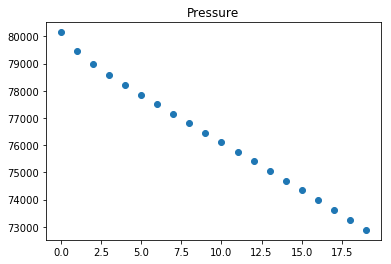

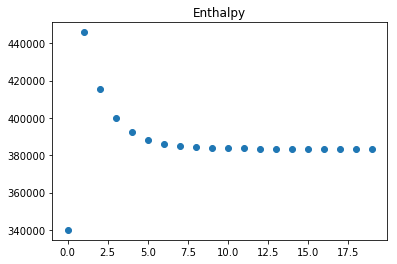

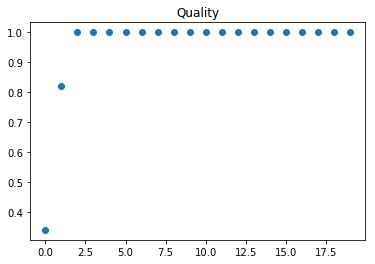

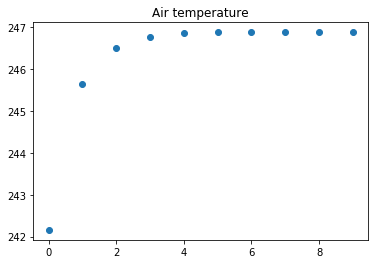

In [134]:
plt.plot(Pr_out,'o')
plt.title('Pressure')
plt.show()
plt.plot(hr_out,'o')
plt.title('Enthalpy')
plt.show()
plt.plot(Qr_in,'o')
plt.title('Quality')
plt.show()
plt.plot(Ta_out,'o')
plt.title('Air temperature')
plt.show()

# Rotina que não funciona

####################
### Main Routine ###
####################

tube_it=1000000000
air_it=10000000000
cycle_it=100000000

alpha_tube = 0.2
alpha_air = 0.2
alpha_cycle = 0.2

Tol_cycle = 1e-3
Tol_air = 1e-3
Tol_tube = 1e-3
tol_dryout = 1e-4


for res in range(cycle_it):
    
    hr_out_cycle_old = np.copy(hr_out)
    Pr_out_cycle_old = np.copy(Pr_out)
    Ta_out_cycle_old = np.copy(Ta_out)
    
    ############
    ### Tube ###
    ############
    
    for ind in range(20):

        ind_j,ind_k = j_index(ind,j_circuit)
        Tr_in = prop('T','P',Pr_in[ind],'H',hr_in[ind],'R134a')
        Ta_avg = (Ta_in[int(ind_j)]+Ta_out_cycle_old[int(ind_j)])/2 
        Q_in = abs(prop('Q','P',Pr_in[ind],'H',hr_in[ind],'R134a'))
        #Q_out = abs(prop('Q','P',Pr_out_cycle_old[ind],'H',hr_out_cycle_old[ind],'R134a'))
        Pr_out_old_it = float(np.copy(Pr_out_cycle_old[ind]))
        hr_out_old_it = float(np.copy(hr_out_cycle_old[ind]))
        F_bi = 0.3
        F_mono = 1- F_bi
        F_bi_press = 0.6 

        for res in range(tube_it):
            
            Pr_out_old = Pr_out_old_it
            hr_out_old = hr_out_old_it
            Pr_avg = (Pr_in[ind]+Pr_out_old)/2
            hr_avg = (hr_in[ind]+hr_out_old)/2
            Q_out = abs(prop('Q','P',Pr_out_old,'H',hr_out_old,'R134a'))
            
            Q_avg = (Q_in+Q_out)/2

            rho_r = prop('D','P',Pr_in[ind],'H',hr_in[ind],'R134a')
            v_r = 1/rho_r
            
            if Q_in < 1 and Q_out < 1 :
                mu_r = prop('V','P',Pr_in[ind],'Q',0,'R134a')
                Pr_out_new = movimento(Pr_in[ind],W,D_i,G_r,v_r,mu_r)
                hr_out_new,Q_ht_r[ind] = energia_bi(hr_in[ind],Pr_in[ind],Pr_in[ind],Q_in,mfrr_inlet,Ta_in[int(ind_j)],Ta_avg,Pa_inlet,mfra_inlet/2,W,D_i,Ac[ind_j,ind_k],Ap[ind_j,ind_k],As[ind_j,ind_k],At[ind_j,ind_k],delta_f,k_al,x_t,x_l)

            
            elif Q_in == 1 and Q_out ==1 : 
                mu_r = prop('V','P',Pr_in[ind],'H',hr_in[ind],'R134a')
                Pr_out_new = movimento(Pr_in[ind],W,D_i,G_r,v_r,mu_r)
                hr_out_new,Q_ht_r[ind] = energia_mono(hr_in[ind],Pr_in[ind],Pr_in[ind],hr_in[ind],mfrr_inlet,Ta_in[int(ind_j)],Ta_avg,Pa_inlet,mfra_inlet/2,W,D_i,Ac[ind_j,ind_k],Ap[ind_j,ind_k],As[ind_j,ind_k],At[ind_j,ind_k],delta_f,k_al,x_t,x_l)
                
            elif Q_in < 1 and Q_out == 1:
                         
                while abs(F_bi - F_bi_press) > tol_dryout:
                    
                    #print('dryout')
                    F_bi = F_bi_press
                    rho_r = prop('D','P',Pr_in[ind],'Q',Q_in,'R134a')
                    v_r = 1/rho_r
                    mu_r_bi = prop('V','P',Pr_in[ind],'Q',0,'R134a')
                    Pr_out_bi = movimento(Pr_in[ind],F_bi*W,D_i,G_r,v_r,mu_r_bi)
                    
                    Pr_avg_mono = (Pr_out_bi+Pr_out_old)/2
                    Pr_avg_bi = (Pr_in[ind]+Pr_out_bi)/2
                                
                    rho_r = prop('D','P',Pr_avg_mono,'Q',1,'R134a')
                    v_r = 1/rho_r
                    mu_r_mono = prop('V','P',Pr_avg_mono,'Q',1,'R134a')
                    Pr_out_new = movimento(Pr_out_bi,F_mono*W,D_i,G_r,v_r,mu_r_mono)

                    F_bi_press = (Pr_in[ind] - Pr_out_bi)/(Pr_in[ind] - Pr_out_new)
                    F_mono_press = 1-F_bi_press
                    
                    hr_out_bi,Q_ht_bi = energia_bi(hr_in[ind],Pr_in[ind],Pr_avg_bi,Q_in,mfrr_inlet,Ta_in[int(ind_j)],Ta_avg,Pa_inlet,F_bi_press*mfra_inlet/2,F_bi_press*W,D_i,F_bi_press*Ac[ind_j,ind_k],F_bi_press*Ap[ind_j,ind_k],F_bi_press*As[ind_j,ind_k],F_bi_press*At[ind_j,ind_k],delta_f,k_al,x_t,x_l)
                    hr_out_new,Q_ht_mono = energia_mono(hr_out_bi,Pr_out_bi,Pr_avg_mono,hr_out_bi,mfrr_inlet,Ta_in[int(ind_j)],Ta_avg,Pa_inlet,F_mono_press*mfra_inlet/2,F_mono_press*W,D_i,F_mono_press*Ac[ind_j,ind_k],F_mono_press*Ap[ind_j,ind_k],F_mono_press*As[ind_j,ind_k],F_mono_press*At[ind_j,ind_k],delta_f,k_al,x_t,x_l)

                    Q_ht_r[ind] = Q_ht_bi+Q_ht_mono
                    #Q_out=1
                    
                    #A_bi = energia_dryout(hr_in[ind],hr_out_bi,Pr_in[ind],Pr_avg,Q_in,mfrr_inlet,Ta_in[int(ind_j)],Ta_avg,Pa_inlet,mfra_inlet/2,W,D_i,Ac[ind_j,ind_k],Ap[ind_j,ind_k],As[ind_j,ind_k],At[ind_j,ind_k],delta_f,k_al,x_t,x_l)
                    #F_bi = A_bi/At[ind_j,ind_k]
                    #F_mono = 1-F_bi
                    
                    #print(F_bi,F_bi_press)
                    
            Pr_out_old_it = alpha_tube*Pr_out_old + (1-alpha_tube)*Pr_out_new
            hr_out_old_it = alpha_tube*hr_out_old + (1-alpha_tube)*hr_out_new
                
            res_P_tube = abs(Pr_out_new - Pr_out_old)
            res_h_tube = abs(hr_out_new - hr_out_old)
            
            res_tube =max(res_h_tube,res_P_tube)
            #print(res_tube)
            
            if res_tube < Tol_tube:
                
                break
            
            else:
                  
                continue
            
        Pr_out_cycle_new[ind]= Pr_out_new
        hr_out_cycle_new[ind]= hr_out_new

    ###########
    ### Air ###
    ###########
    
    for ind2 in range(10):
        
        tube_index = j_circuit[ind2]
        Ta_out_old_it = float(np.copy(Ta_out_cycle_old[ind2]))
        
        for res in range(air_it):
            
            Ta_out_old = Ta_out_old_it
            Tair_avg = (Ta_in[ind2]+Ta_out_old)/2
            Q_ht_air = Q_ht_r[int(tube_index[0])] + Q_ht_r[int(tube_index[1])]
            Ta_out_new = energia_ar(Ta_in[ind2],Tair_avg,Pa_inlet,mfra_inlet,Q_ht_air)
            
            Ta_out_old_it = alpha_air*Ta_out_old + (1-alpha_air)*Ta_out_new
            res_air = abs(Ta_out_new - Ta_out_old)
            #print(res_air) 
                
            if res_air < Tol_air:

                break

            else:
              
                continue
            
        Ta_out_cycle_new[ind2] = Ta_out_new
                  
    ###############################################        
    ### Cycle convergency  and sub-relaxatation ###
    ###############################################
    
    res_P_cycle = max(abs(Pr_out_cycle_new - Pr_out_cycle_old))
    res_h_cycle = max(abs(hr_out_cycle_new - hr_out_cycle_old))
    res_Ta_cycle = max(abs(Ta_out_cycle_new - Ta_out_cycle_old))
    res_cycle=max(res_h_cycle,res_P_cycle,res_Ta_cycle)
    print(res_cycle)
    
    if res_cycle < Tol_cycle:

        for ind3 in range(20):

            hr_out[ind3] = hr_out_cycle_new[ind3]
            Pr_out[ind3] = Pr_out_cycle_new[ind3]

            if ind3 != 19:

                Pr_in[ind3+1]=Pr_out[ind3]
                hr_in[ind3+1]=hr_out[ind3]


        for ind4 in range(10):

            Ta_out[ind4] = Ta_out_cycle_new[ind4]

            if ind4 != 9:

                Ta_in[ind4+1]=Ta_out[ind4]
                
        break
    
    else:
        
        for ind3 in range(20):

            hr_out[ind3] = hr_out_cycle_old[ind3]*alpha_cycle + hr_out_cycle_new[ind3]*(1-alpha_cycle) 
            Pr_out[ind3] = Pr_out_cycle_old[ind3]*alpha_cycle + Pr_out_cycle_new[ind3]*(1-alpha_cycle)

            if ind3 != 19:

                Pr_in[ind3+1]=Pr_out[ind3]
                hr_in[ind3+1]=hr_out[ind3]


        for ind4 in range(10):

            Ta_out[ind4] = Ta_out_cycle_old[ind4]*alpha_cycle + Ta_out_cycle_new[ind4]*(1-alpha_cycle)

            if ind4 != 9:

                Ta_in[ind4+1]=Ta_out[ind4]
            
        continue
    
    
for index in range(20):
    
    Qr_out[index] = abs(prop('Q','P',Pr_out[index],'H',hr_out[index],'R134a'))
    Qr_in[index] = abs(prop('Q','P',Pr_in[index],'H',hr_in[index],'R134a'))
    Tref_out[index] = abs(prop('T','P',Pr_out[index],'H',hr_out[index],'R134a'))
    Tref_in[index] = abs(prop('T','P',Pr_in[index],'H',hr_in[index],'R134a'))


def energia_dryout(hin,Q_ht_bif,Pin,Pavg,Qavg,mfrin,Tain,Taavg,Pa,mfra,L,Di,A_c,A_p,A_s,A_t,deltaf,kal,xt,xl):
    
    Qin = prop('Q','P',Pin,'H',hin,'R134a')
    #hsat = prop('H','P',Pavg,'Q',1,'R134a')
    Tin = prop('T','P',Pin,'H',hin,'R134a')
    
    rho_a = prop('D','T',Taavg,'P',Pa,'Air')
    mu_a = prop('D','T',Taavg,'P',Pa,'Air')
    Pr_a = prop('PRANDTL','T',Taavg,'P',Pa,'Air')
    cp_a = prop('C','T',Taavg,'P',Pa,'Air')
    C_a = mfra*cp_a
    cp_r=prop('C','P',Pavg,'Q',Qavg,'R134a')    
    C_r = mfrin*cp_r
    
    #Taout = 2*Taavg-Tain
    eff_dryout = abs(Q_ht_bif)/(C_a*(Tain-Tin))
    #eff_dryout = C_a*(Tain - Taout)/(C_a*(Tain-Tin))
    NTU_dryout = NUT(C_a,C_r,eff_dryout,Qin)
    
    mu_l =prop('V','P',Pavg,'Q',0,'R134a')
    mu_v = prop('V','P',Pavg,'Q',1,'R134a')
    rho_l = prop('D','P',Pavg,'Q',0,'R134a')
    rho_v = prop('D','P',Pavg,'Q',1,'R134a')
    
    G = mfrin/(np.pi*Di**2/4)
    G_l = G*(1-Qavg)
    G_v = G*Qavg
    Re_l = G_l*Di/mu_l
    Re_v = G_v*Di/mu_v
    f_l =f_chur(Re_l,Di)
    f_v =f_chur(Re_v,Di)
    
    xtt = Xtt(Qavg,G,Di,f_l,rho_l,f_v,rho_v)
    Re_lo = G*Di/prop('V','P',Pavg,'Q',0,'R134a')
    Pr_lo = prop('PRANDTL','P',Pavg,'Q',0,'R134a')
    k_lo = prop('L','P',Pavg,'Q',0,'R134a')
    
    etabi=eta_bifasico(Re_lo,xtt,Pr_lo,k_lo,Di)

    #mfr_a = rho_a*vfrin
    G_a= (mfra/A_c)
    Re_a = G_a*D_o/mu_a
    
    eta_a = eta_air(Re_a,Pr_a,G_a,cp_a,A_p,A_s)
    eff_surf = surf_eff(A_p,A_s,Di,deltaf,eta_a,kal,xt,xl)
    
    
    U = (A_t/(etabi*np.pi*Di*L) + 1/(eff_surf*eta_a))**-1
    #print(eff_dryout)
    parameter = NTU_dryout*C_a/U
    
    return(parameter)
